## Results of Host Prediction
### Dataset: Coronaviridae S prot UniRef90, EMBL mapping, Vertebrates

**Models**: TF - Pretrain  + finetune

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1336

**Alignment**: Yes, No

**Classification**: Multi-class

**\# classes**: 8, 2

**\# train samples** = 

**\# validation samples** = 

**\# test samples** = 


In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/miniconda3/envs/zoonosis/lib/python311.zip',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/lib-dynload',
 '',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../..']

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import utils, evaluation_utils, visualization_utils
from sklearn.metrics import auc, precision_recall_curve
from statistics import mean

In [3]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
human_col = "Human"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['figure.autolayout'] = True

DEFAULT_FIGURE_CONFIG = {
    "figsize": (10, 10),
    "xtick.labelsize": 14,
    "ytick.labelsize": 14    
}


def plot_auprc(auprc_df, metadata, model_name):
    # sort by median
    sorted_median_auprc_df = auprc_df.groupby("class")["auprc"].median().sort_values(ascending=False)
    visualization_utils.pre_plot_config(DEFAULT_FIGURE_CONFIG)
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    ax = sns.boxplot(data=auprc_df, x="class", y="auprc", order=sorted_median_auprc_df.index)
    
    ax.set_ylim(0, 1)
    ax.set_title(f"Model = {model_name}")
    plt.tight_layout()
    plt.xticks(rotation=-90)
    plt.show()
        
def auprc_analysis(output_filepath, model_name):
    df = pd.read_csv(output_filepath, index_col=0)
    print(f"Read output size = {df.shape}")
    cols = df.columns
    non_human_cols = list(set(cols) - set([itr_col, experiment_col, y_true_col, human_col]))
    print(f"NonHuman cols = {non_human_cols}")
    itrs = df[itr_col].unique()
    
    auprc = []
    pr_curves = []
    for itr in itrs:
        df_itr = df[df[itr_col] == itr]
        pr_curves_df, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=non_human_cols + [human_col], y_true_col=y_true_col)
        pr_curves_df[itr_col] = itr
        auprcs_df[itr_col] = itr
        auprc.append(auprcs_df)
        pr_curves.append(pr_curves_df)

    auprc_df = pd.concat(auprc, ignore_index=True)
    pr_curves_df = pd.concat(pr_curves, ignore_index=True)
    
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    
    plot_auprc(auprc_df, metadata, model_name)
    visualization_utils.curve_plot(pr_curves_df, x_col="recall", y_col="precision",
                                   color_group_col="class", style_group_col=None,
                                   output_file_path=None, metadata=metadata)
    

In [8]:
def class_wise_auprc_analysis(output_filepaths, classes, figure_output_filepath=None):
    auprc_results = []
    for model, output_filepath in output_filepaths.items():
        df = pd.read_csv(output_filepath, index_col=0)
        print(f"Read output {model} = {df.shape}")
        
        cols = df.columns
        classes = list(set(cols) - set([itr_col, experiment_col, y_true_col]))
        itrs = df[itr_col].unique()
    
        for itr in itrs:
            df_itr = df[df[itr_col] == itr]
            _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
            auprcs_df = auprcs_df.append({"class": "Macro-AUPRC", "auprc": auprcs_df["auprc"].mean()}, ignore_index=True)
            auprcs_df["model"] = model
            auprcs_df["itr"] = itr
            auprc_results.append(auprcs_df)
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=False)
    metadata_formatted = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    metadata_sorted = {}
    for k, v in metadata.items():
        metadata_sorted[metadata_formatted[k]] = v
    metadata_sorted["Macro-AUPRC"] = 0
    auprc_results_df = pd.concat(auprc_results, ignore_index=True)
    auprc_results_df.replace({"class":metadata_formatted}, inplace=True)
    
    FIGURE_CONFIG = {
        "figsize": (10, 8),
        "xtick.labelsize": 14,
        "ytick.labelsize": 14    
    }

    visualization_utils.pre_plot_config(FIGURE_CONFIG)
    ax = sns.boxplot(data=auprc_results_df, x="class", y="auprc", hue="model", order=metadata_sorted)
    plt.draw()
    
    ax.set_ylim(0, 1)
    ax.set_ylabel("AUPRC", size=18)
    ax.set_xlabel("Classes", size=18, labelpad=2)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=False)
    plt.setp(ax.get_legend().get_texts(), fontsize=16)
    visualization_utils.wrap_ticklabels(ax, axis="x")
    # visualization_utils.view(figure_output_filepath)
    plt.show()
    return auprc_results_df

In [9]:
def compute_binary_auprc(df, y_true_col, pos_label):
    precision, recall, _ = precision_recall_curve(y_true=df[y_true_col].values, probas_pred=df[pos_label].values, pos_label=pos_label)
    return auc(recall, precision)

def compute_multi_auprc(df, y_true_col):
    label_values = list(df[y_true_col].unique())
    auprcs = []
    for label_value in label_values:
        precision, recall, _ = precision_recall_curve(y_true=df[y_true_col].values, probas_pred=df[label_value].values, pos_label=label_value)
        auprcs.append(auc(recall, precision))
    
    return mean(auprcs)

### UniProt

In [10]:
file_paths = {
    "sl128-st64": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240805/host_multi/fine_tuning_hybrid/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl128b1024vs30_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    "sl128-st64-cls": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240805/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl128b1024vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    "sl256-st64": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240805/host_multi/fine_tuning_hybrid/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b1024vs30_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    "sl256-st64-cls": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240805/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b1024vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv")
}

classes = ["Pig", "Human", "Cat", "Dromedary camel", "Cattle", "Chicken", "Gray wolf", "Yak"]

Read output sl128-st64 = (1785, 10)
Read output sl128-st64-cls = (1785, 10)
Read output sl256-st64 = (1785, 10)
Read output sl256-st64-cls = (1785, 10)


/tmp/ipykernel_484009/2237001991.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  auprcs_df = auprcs_df.append({"class": "Macro-AUPRC", "auprc": auprcs_df["auprc"].mean()}, ignore_index=True)
/tmp/ipykernel_484009/2237001991.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  auprcs_df = auprcs_df.append({"class": "Macro-AUPRC", "auprc": auprcs_df["auprc"].mean()}, ignore_index=True)
/tmp/ipykernel_484009/2237001991.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  auprcs_df = auprcs_df.append({"class": "Macro-AUPRC", "auprc": auprcs_df["auprc"].mean()}, ignore_index=True)
/tmp/ipykernel_484009/2237001991.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version.

<Figure size 640x480 with 0 Axes>

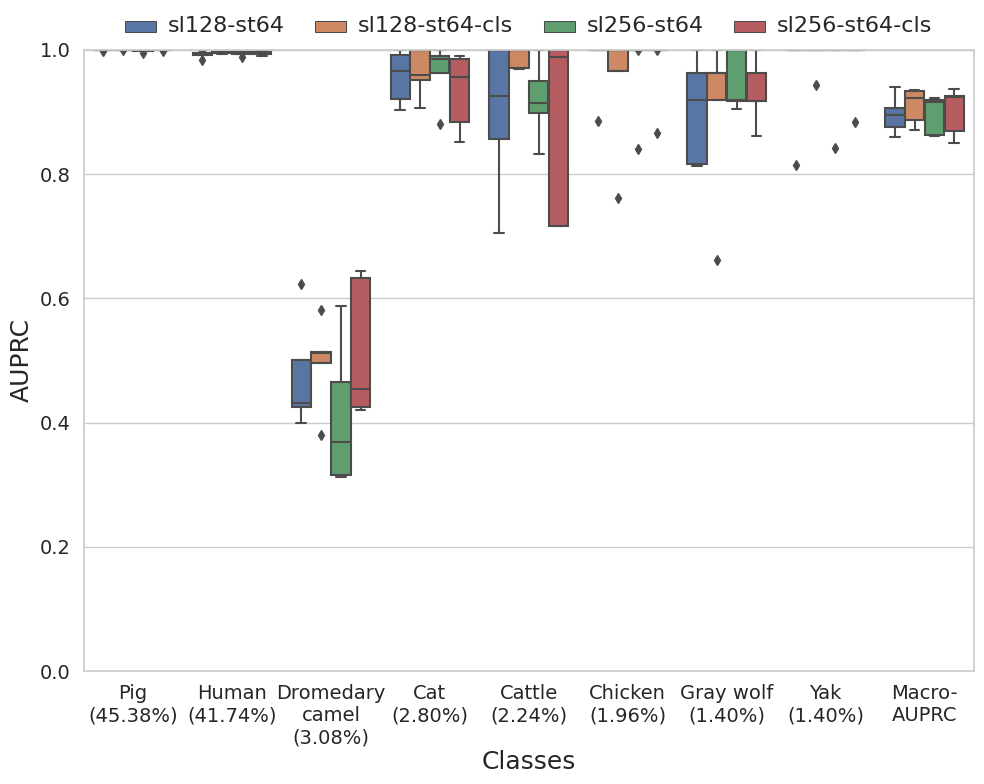

,class,auprc,model,itr
0,Cattle (2.24%),0.856529,sl128-st64,0
1,Yak (1.40%),1.000000,sl128-st64,0
2,Dromedary camel (3.08%),0.424626,sl128-st64,0
3,Pig (45.38%),0.998856,sl128-st64,0
4,Gray wolf (1.40%),0.812698,sl128-st64,0
...,...,...,...,...
175,Gray wolf (1.40%),1.000000,sl256-st64-cls,4
176,Human (41.74%),0.996531,sl256-st64-cls,4
177,Cat (2.80%),0.851584,sl256-st64-cls,4
178,Chicken (1.96%),1.000000,sl256-st64-cls,4


In [11]:
class_wise_auprc_analysis(file_paths, classes)

### UniRef90

In [12]:


file_paths = {
    "sl128-st64": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240805/host_multi/fine_tuning_hybrid/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl128b64vs30_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    "sl128-st64-cls": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240805/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl128b1024vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    "sl256-st64": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240805/host_multi/fine_tuning_hybrid/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b64vs30_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    "sl256-st64-cls": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240805/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b1024vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv")
}

classes = ["Chicken", "Human", "Cat", "Pig", "Gray wolf", "Horshoe bat", "Ferret", "Chinese rufous horseshoe bat"]

Read output sl128-st64 = (345, 10)
Read output sl128-st64-cls = (345, 10)
Read output sl256-st64 = (345, 10)
Read output sl256-st64-cls = (345, 10)


/tmp/ipykernel_484009/2237001991.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  auprcs_df = auprcs_df.append({"class": "Macro-AUPRC", "auprc": auprcs_df["auprc"].mean()}, ignore_index=True)
/tmp/ipykernel_484009/2237001991.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  auprcs_df = auprcs_df.append({"class": "Macro-AUPRC", "auprc": auprcs_df["auprc"].mean()}, ignore_index=True)
/tmp/ipykernel_484009/2237001991.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  auprcs_df = auprcs_df.append({"class": "Macro-AUPRC", "auprc": auprcs_df["auprc"].mean()}, ignore_index=True)
/tmp/ipykernel_484009/2237001991.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version.

<Figure size 640x480 with 0 Axes>

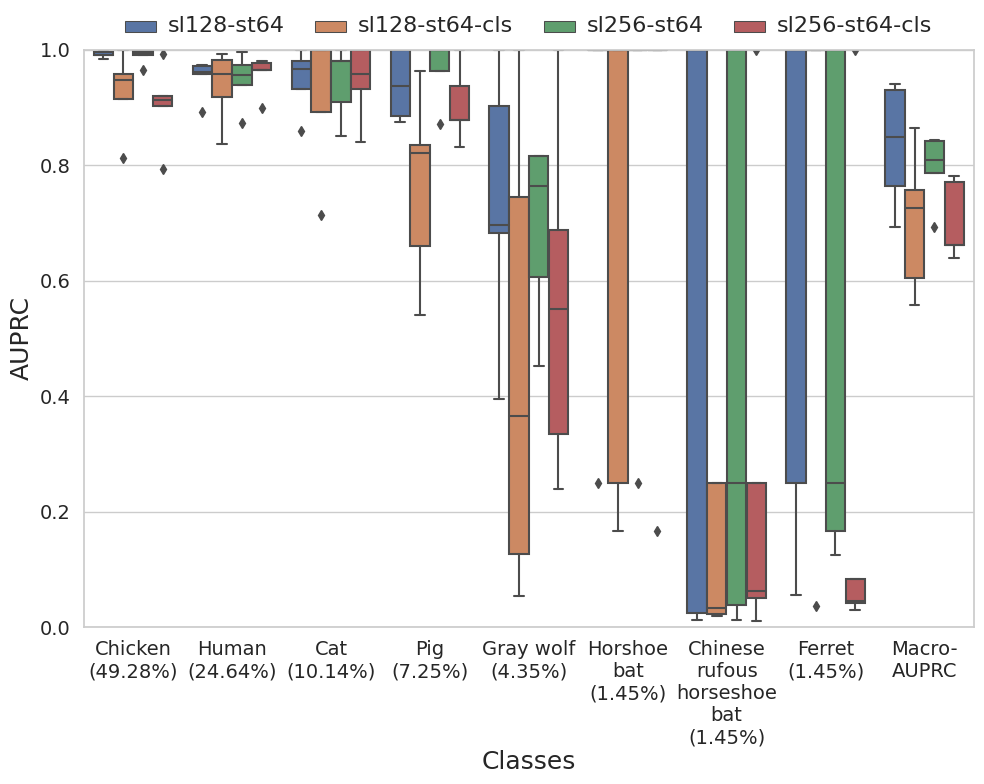

,class,auprc,model,itr
0,Horshoe bat (1.45%),1.000000,sl128-st64,0
1,Chinese rufous horseshoe bat (1.45%),1.000000,sl128-st64,0
2,Pig (7.25%),0.885455,sl128-st64,0
3,Gray wolf (4.35%),0.682511,sl128-st64,0
4,Ferret (1.45%),1.000000,sl128-st64,0
...,...,...,...,...
175,Ferret (1.45%),0.029412,sl256-st64-cls,4
176,Human (24.64%),0.977988,sl256-st64-cls,4
177,Cat (10.14%),1.000000,sl256-st64-cls,4
178,Chicken (49.28%),0.902437,sl256-st64-cls,4


In [13]:
class_wise_auprc_analysis(file_paths, classes)